Here we fit FA models across fish, looking at the latent representations of different conditions for all fish in the same 
low-d space.  We initialize with shared posteriors, use these for initialization when fitting with the individual posteriors and then use early stopping to prevent overfitting when fitting with the individual posteriors.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
from itertools import chain
from pathlib import Path

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import DenseLNLNet
from janelia_core.ml.utils import list_torch_devices
from janelia_core.visualization.image_generation import max_project_pts
from janelia_core.visualization.matrix_visualization import cmp_n_mats


from ahrens_wbo.annotations import label_subperiods
from ahrens_wbo.data_processing import load_and_preprocess_data
from probabilistic_model_synthesis.fa import orthonormalize
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import evaluate_check_points
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import generate_basic_posteriors
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import generate_hypercube_prior_collection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import infer_latents
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import GNLDRMdl
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import PriorCollection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import VICollection

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
ps = dict()

# Specify the directory where all the raw data is found
ps['data_dir'] = r'/groups/bishop/bishoplab/projects/ahrens_wbo/data'

# Here we list the subject we want to fit and the conditions we want to fit on for each subject
ps['fit_specs'] = {8: ['omr_forward'], 
                   9: ['omr_left'], 
                   11: ['omr_right']} 
               
# Here we specify if we fit in conditions with shock or not
ps['shock'] = False

# Number of latent variables in the model
ps['n_latent_vars'] = 10

# Number of inidividual slices of each type of subperiod we use for validation
ps['n_validation_slices'] = 2

# True if we should use GPUs for fitting if they are available
ps['use_gpus'] = True

# Options for setting up hypercube functions
ps['hc_opts'] = {'n_divisions_per_dim': [50, 30, 17], 
                 'dim_ranges': np.asarray([[0, 990.0], [0, 610.0], [0, 350.0]]),
                 'n_div_per_hc_side_per_dim': [1, 1, 1]}

# Parameters for the priors on scales
ps['s_mn'] = 1.0
ps['s_std'] = .0001

# True if we should use early stopping
ps['use_early_stopping'] = True

# Folder where checkpoints will be saved
ps['cp_save_folder'] = r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/glndr_testing/across_cond_cps'

## See which devices are available for fitting

In [5]:
if ps['use_gpus']:
    devices, _ = list_torch_devices()
else:
    devices = [torch.device('cpu')]

Found 1 GPUs


## Load the data for each subject

In [6]:
subjects = list(ps['fit_specs'].keys())
n_subjects = len(subjects)

In [7]:
datasets, neuron_locs = load_and_preprocess_data(data_folder=ps['data_dir'], 
                                                 subjects=subjects, 
                                                 neural_gain=10)

Done loading data for subject subject_8.
Done loading data for subject subject_9.
Done loading data for subject subject_11.


## Form the fitting and validation data for each subject

In [8]:
all_subperiods = set(chain(*[v for v in ps['fit_specs'].values()]))
label_map = {sp: sp_i for sp_i, sp in enumerate(all_subperiods)}

In [9]:
fit_data = dict()
validation_data = dict()
fit_labels = dict()
validation_labels = dict()

for s_n, dataset in datasets.items():
    
    data_n = datasets[s_n].ts_data['dff']['vls'][:]
    
    # Label the subperiods for this subject
    subperiods = label_subperiods(dataset.ts_data['stim']['vls'][:])
    
    # Down select to only the subperiods we want to fit on for this subject
    subperiods = {k:v for k, v in subperiods.items() if k in ps['fit_specs'][s_n]}
    
    # Down select to the shock condition we want to fit
    subperiods = {k: [sp_i for sp_i in v if sp_i['shock'] == ps['shock']] for k, v in subperiods.items()} 
    
    # Randomly select subperiods for training and validation
    fit_subperiods = dict()
    validation_subperiods = dict()
    for sp_key, sp_slices in subperiods.items():
        
        n_slices = len(sp_slices)
        validation_inds = np.random.choice(n_slices, ps['n_validation_slices'], replace=False)
        
        validation_slices = [sp_slices[s_i] for s_i in range(n_slices) if s_i in validation_inds]
        fit_slices = [sp_slices[s_i] for s_i in range(n_slices) if s_i not in validation_inds]
        
        validation_subperiods[sp_key] = validation_slices
        fit_subperiods[sp_key] = fit_slices

    # Pull out the fitting data for this subject
    fit_data[s_n] = {k:np.concatenate([data_n[sl['slice'], :] for sl in v], axis=0) 
                     for k, v in fit_subperiods.items()}
    
    validation_data[s_n] = {k:np.concatenate([data_n[sl['slice'], :] for sl in v], axis=0) 
                            for k, v in validation_subperiods.items()}
    
    # Generate numerical labels for each data point
    fit_labels[s_n] = {k:label_map[k]*np.ones(np.sum([sl_i['slice'].stop - sl_i['slice'].start for sl_i in v])) 
                       for k, v in fit_subperiods.items()}
    validation_labels[s_n] = {k:label_map[k]*np.ones(np.sum([sl_i['slice'].stop - sl_i['slice'].start for sl_i in v])) 
                              for k, v in validation_subperiods.items()}
    

In [10]:
fit_data_conc = {k: np.concatenate([data for data in v.values()], axis=0) 
                 for k, v in fit_data.items()}
fit_labels_conc = {k: np.concatenate([lbls for lbls in v.values()], axis=0) 
                   for k, v in fit_labels.items()}

validation_data_conc = {k: np.concatenate([data for data in v.values()], axis=0) 
                        for k, v in validation_data.items()}
validation_labels_conc = {k: np.concatenate([lbls for lbls in v.values()], axis=0) 
                          for k, v in validation_labels.items()}

## Prepare things we will need for eventual plotting

In [11]:
n_subperiods = len(label_map)
subperiod_clrs = {k: cm.Set1(k_i/(n_subperiods-1)) for k_i, k in enumerate(label_map.keys())}
subject_markers = {8: 'o', 9: 'v', 10: 's', 11:'X'}

## Setup everything for fitting sp models

In [12]:
ind_n_vars = [validation_data_conc[s_n].shape[1] for s_n in subjects]

In [13]:
sp_m_fit = torch.nn.Identity()

In [14]:
sp_priors = generate_hypercube_prior_collection(n_intermediate_latent_vars=ps['n_latent_vars'],
                                                hc_params = ps['hc_opts'], s_mn=ps['s_mn'] , s_std=ps['s_std'] )
    
sp_posteriors = generate_basic_posteriors(n_obs_vars=[fit_data_conc[s_n].shape[1] for s_n in subjects], 
                                          n_smps=[fit_data_conc[s_n].shape[0] for s_n in subjects], 
                                          n_latent_vars=ps['n_latent_vars'], 
                                          n_intermediate_latent_vars=ps['n_latent_vars'],
                                          s_opts={'mn_mn': ps['s_mn'], 'mn_std': .00000001, 
                                                  'std_lb': ps['s_std']-.0001, 'std_iv': ps['s_std']})

sp_posteriors = {s_n: sp_posteriors[s_i] for s_i, s_n in enumerate(subjects)}

sp_fit_mdls = {s_n: GNLDRMdl(n_latent_vars=ps['n_latent_vars'], m=sp_m_fit) for s_n in subjects}
                    
                                    
sp_vi_collections = [VICollection(data=torch.tensor(fit_data_conc[s_n]), 
                                  props=neuron_locs[s_n],
                                  mdl = sp_fit_mdls[s_n],
                                  posteriors = sp_posteriors[s_n]) for s_n in subjects]

for vi_coll in sp_vi_collections:
    vi_coll.posteriors.lm_post = sp_priors.lm_prior
    vi_coll.posteriors.mn_post = sp_priors.mn_prior

## Fit the sp models

In [15]:
sp_fitter = Fitter(vi_collections=sp_vi_collections, priors=sp_priors, devices=devices)

In [16]:
sp_fitter.distribute(distribute_data=True, devices=devices)
sp_logs = [sp_fitter.fit(1000, milestones=[500], update_int=100, init_lr=.1) for fit_r in range(1)]
sp_fitter.distribute(devices=[torch.device('cpu')])


=========== EPOCH 0 COMPLETE ===========
Obj: 6.28e+10
----------------------------------------
NELL: 9.57e+07, 2.27e+07, 2.80e+07
Latent KL: 2.68e+02, 6.71e+01, 6.88e+01
LM KL: 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00
Psi KL: 1.72e+04, 1.88e+04, 2.38e+04
S KL: 1.73e+10, 1.99e+10, 2.54e+10
----------------------------------------
LR: 0.1
Elapsed time (secs): 1.2246837615966797
----------------------------------------
CPU cur memory used (GB): 2.67e+01
GPU_0 cur memory used (GB): 2.34e-01, max memory used (GB): 2.34e-01

=========== EPOCH 100 COMPLETE ===========
Obj: 6.36e+07
----------------------------------------
NELL: 4.13e+07, 1.00e+07, 1.20e+07
Latent KL: 1.71e+04, 3.17e+03, 2.99e+03
LM KL: 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00
Psi KL: 6.68e+04, 6.83e+04, 7.72e+04
S KL: 3.86e+01, 1.33e+01, 1.98e+01
----------------------------------------
LR: 0.1
Elapsed time (secs): 36.30798387527466
----------------------------------------
CPU

## Examine logs of sp fitting performance

<IPython.core.display.Javascript object>


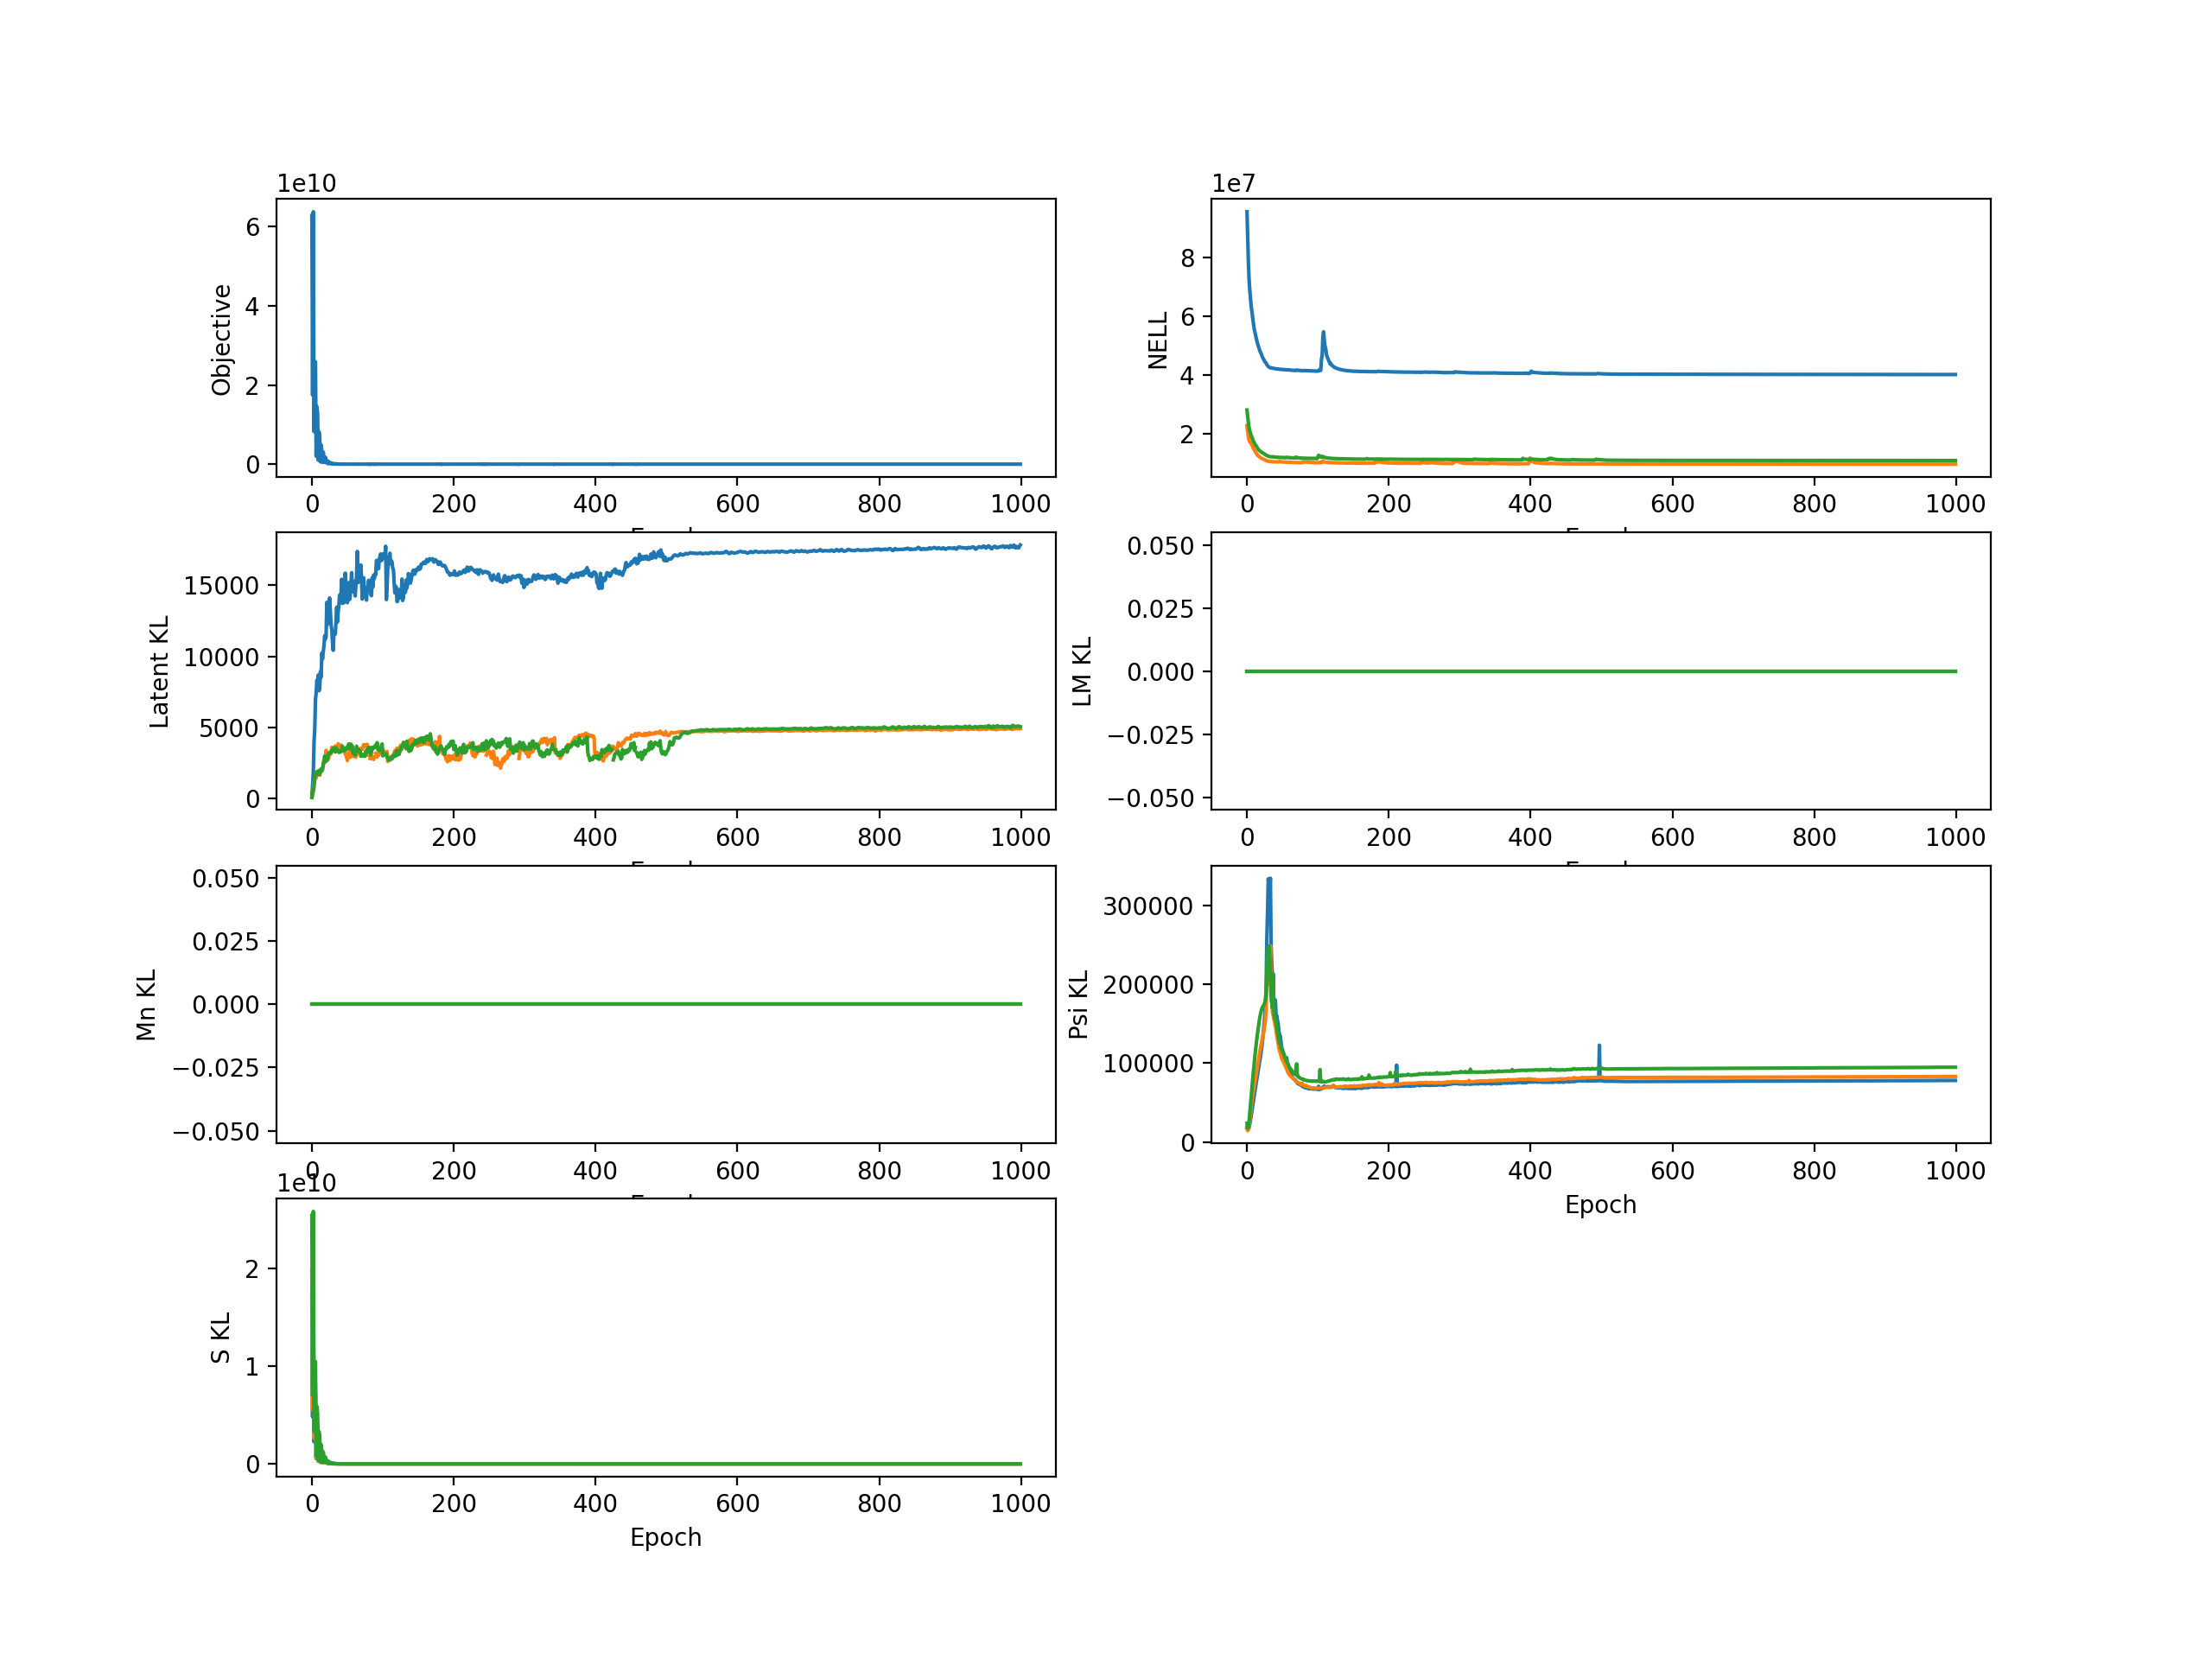

In [17]:
for log in sp_logs:
    sp_fitter.plot_log(log)

## View orthonormalized latents estimated with the sp models



In [18]:
view_validaton = False # True if we should view validation latents

In [19]:
sp_latents = {s_n: sp_posteriors[s_n].latent_post.mns.detach().numpy() for s_n in subjects}

In [20]:
sp_lm_conc = torch.cat([post.lm_post(props) for post, props in zip(sp_posteriors.values(), neuron_locs.values())],
                       dim=0).detach().numpy()

In [21]:
sp_latents_o = {s_n: orthonormalize(lm=sp_lm_conc, latents=latents_n) for s_n, latents_n in sp_latents.items()}
sp_latents_o = {s_n: vls[1] for s_n, vls in sp_latents_o.items()}

<IPython.core.display.Javascript object>


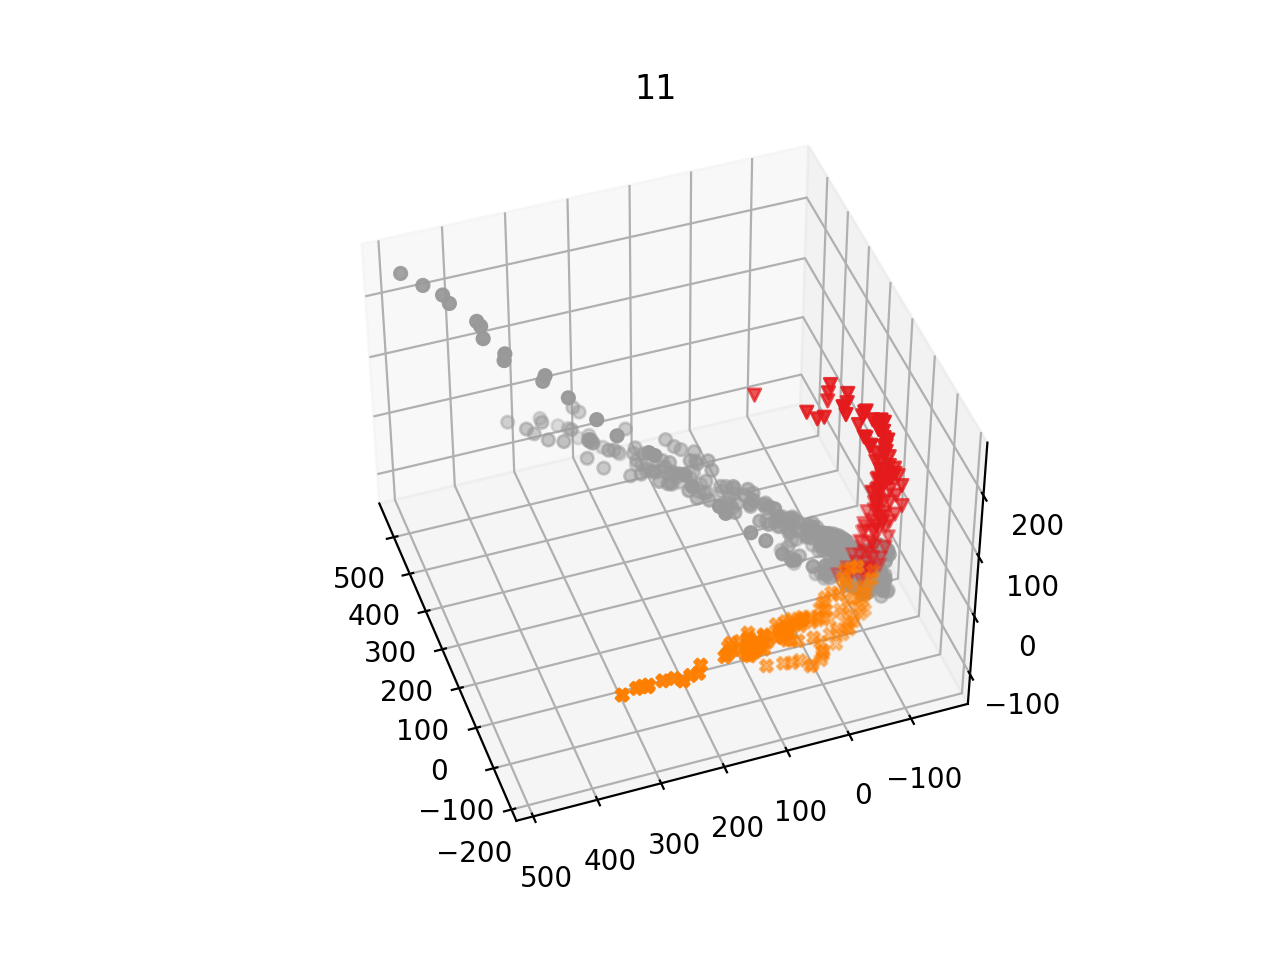

In [48]:
start_dim=0

plt.figure()
ax = plt.axes(projection='3d')
for s_n in subjects:
    plot_latents = sp_latents_o[s_n]
    if view_validaton:
        plot_labels = validation_labels_conc[s_n]
    else:
        plot_labels = fit_labels_conc[s_n]
    
    for sp, sp_lbl in label_map.items():
        sp_clr = subperiod_clrs[sp]
        sp_inds = plot_labels == sp_lbl
        ax.scatter(plot_latents[sp_inds,start_dim+0], plot_latents[sp_inds,start_dim+1], 
                   plot_latents[sp_inds,start_dim+2], color=sp_clr, marker=subject_markers[s_n])
    plt.title(str(s_n))

## Visualize loading matrices across space for the sp models

In [23]:
vis_comp = 1

In [24]:
sp_lm_o_conc = orthonormalize(lm=sp_lm_conc)
sp_lm_o_conc = sp_lm_o_conc[0]
sp_lm_o = dict()
cur_start = 0
for s_n in subjects:
    n_vars_n = fit_data_conc[s_n].shape[1]
    sp_lm_o[s_n] = sp_lm_o_conc[cur_start:cur_start+n_vars_n]
    cur_start += n_vars_n

<IPython.core.display.Javascript object>


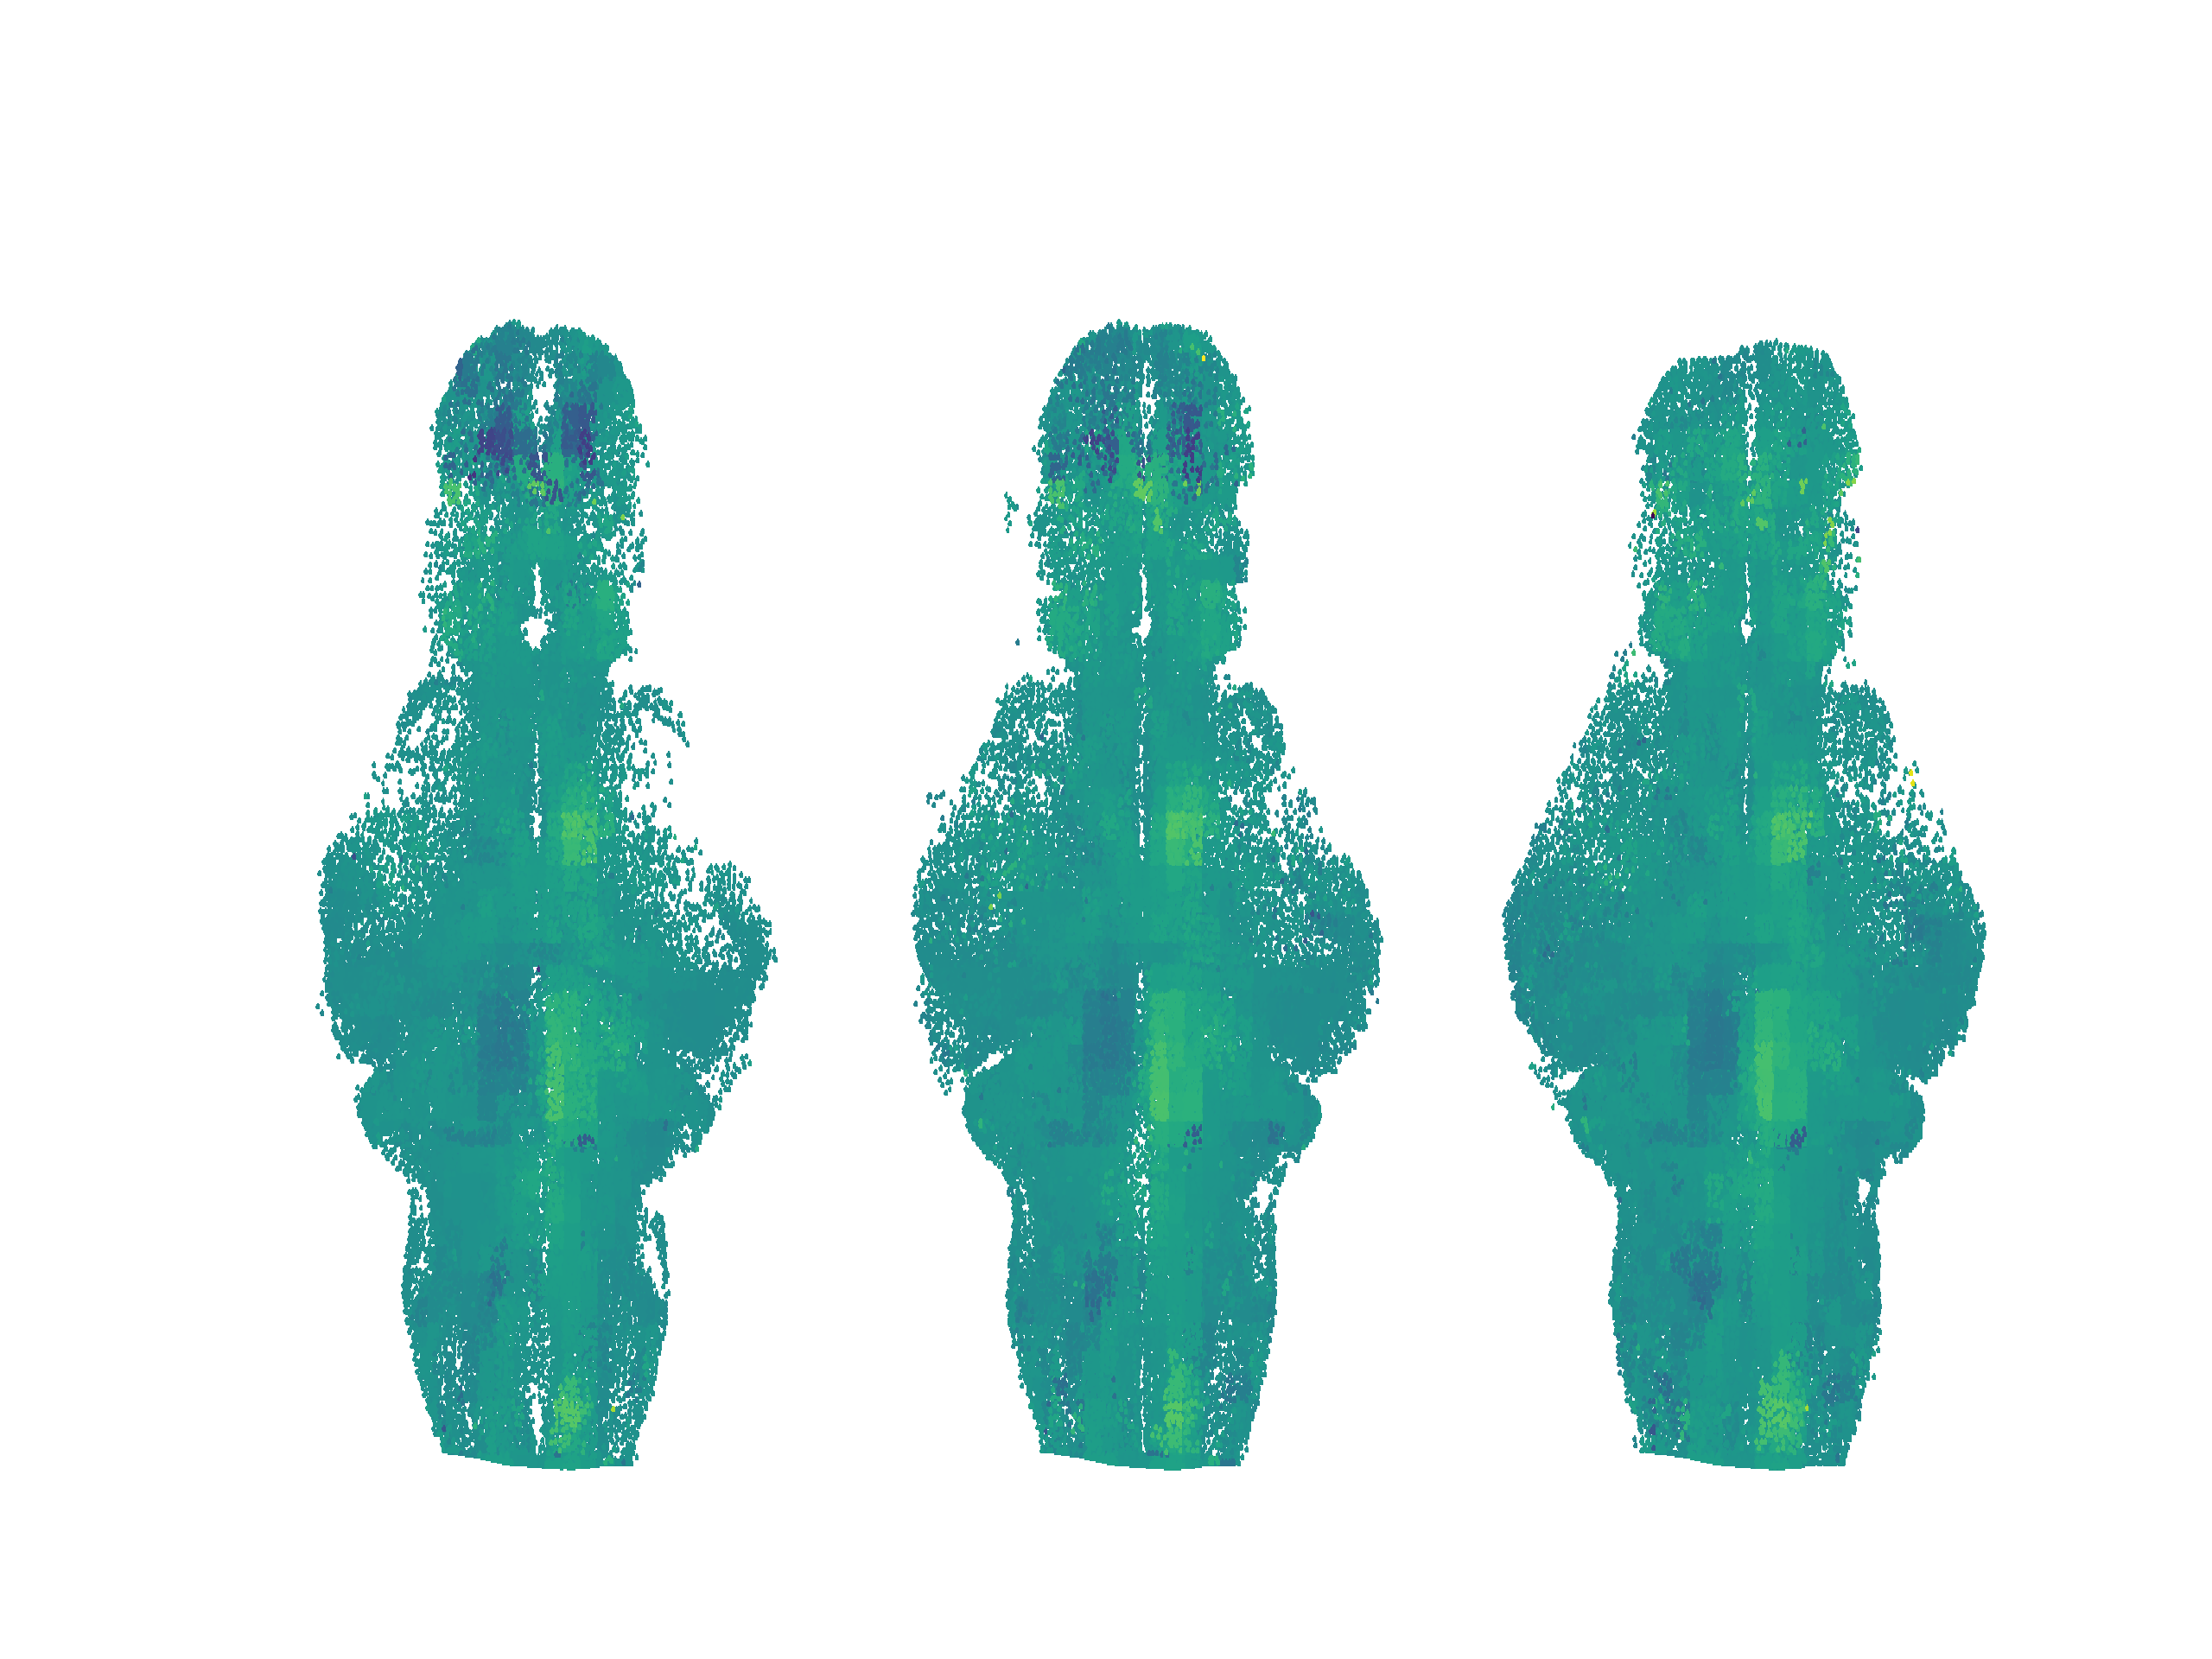

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

In [25]:
mode_imgs = dict()
for s_n in subjects:
    neuron_locs_n = neuron_locs[s_n]
    
    lm_n = sp_lm_o[s_n]
    
    mode_imgs[s_n], _ = max_project_pts(dot_positions=neuron_locs_n.numpy()[:,[0,1]].astype('float'),
                                        dot_vls=lm_n[:,vis_comp], 
                                        box_position=np.asarray([[0, 0], [990, 610]]), 
                                        n_divisions=np.asarray([990, 610]), 
                                        dot_dim_width=np.asarray([5,5]))
    
plt.figure()
cmp_n_mats([mode_imgs[k] for k in mode_imgs.keys()])   

## Setup everything for fitting models with individual posteriors

In [26]:
ip_priors = copy.deepcopy(sp_priors)

ip_posteriors = generate_basic_posteriors(n_obs_vars=[fit_data_conc[s_n].shape[1] for s_n in subjects], 
                                          n_smps=[fit_data_conc[s_n].shape[0] for s_n in subjects], 
                                          n_latent_vars=ps['n_latent_vars'], 
                                          n_intermediate_latent_vars=ps['n_latent_vars'],
                                          s_opts={'mn_mn': ps['s_mn'], 'mn_std': .00000001, 
                                                  'std_lb': ps['s_std']/100, 'std_iv': ps['s_std']})

ip_posteriors = {s_n: ip_posteriors[s_i] for s_i, s_n in enumerate(subjects)}

In [27]:
ip_m_fit = copy.deepcopy(sp_m_fit)

In [28]:
for s_n, posteriors in ip_posteriors.items():
    
    # Initialize the poseteriors for the mean vectors
    with torch.no_grad():
        mn_prior_mn = sp_priors.mn_prior(neuron_locs[s_n]).squeeze()
        mn_prior_std = sp_priors.mn_prior.std_f(neuron_locs[s_n]).squeeze()
    
        posteriors.mn_post.dists[0].mn_f.f.vl.data = copy.deepcopy(mn_prior_mn)
        posteriors.mn_post.dists[0].std_f.f.set_value(copy.deepcopy(mn_prior_std.numpy()))
        
    # Initialize the posteriors for the loading matrices
    with torch.no_grad():
        for d_i in range(ps['n_latent_vars']):
            lm_prior_mn = sp_priors.lm_prior.dists[d_i](neuron_locs[s_n]).squeeze()
            lm_prior_std = sp_priors.lm_prior.dists[d_i].std_f(neuron_locs[s_n]).squeeze()
            
            posteriors.lm_post.dists[d_i].mn_f.f.vl.data = copy.deepcopy(lm_prior_mn)
            posteriors.lm_post.dists[d_i].std_f.f.set_value(copy.deepcopy(lm_prior_std.numpy()))
        
    # Initialize the posteriors for the private variances
    posteriors.psi_post = copy.deepcopy(sp_posteriors[s_n].psi_post)
    
    # Initialize the posteriors for the latents
    with torch.no_grad():
        posteriors.latent_post = copy.deepcopy(sp_posteriors[s_n].latent_post)

In [29]:
ip_fit_mdls = {s_n: GNLDRMdl(n_latent_vars=ps['n_latent_vars'], m=ip_m_fit) for s_n in subjects}

ip_vi_collections = [VICollection(data=torch.tensor(fit_data_conc[s_n]), 
                                  props=neuron_locs[s_n],
                                  mdl = ip_fit_mdls[s_n],
                                  posteriors = ip_posteriors[s_n])
                     for s_n in subjects]

## Fit the ip models

In [30]:
ip_fitter = Fitter(vi_collections=ip_vi_collections, priors=ip_priors)

In [31]:
ip_fitter.distribute(distribute_data=True, devices=devices)
ip_log = ip_fitter.fit(200, milestones=[500, 700], update_int=100, init_lr=0.001,
                       cp_save_folder=ps['cp_save_folder'], cp_epochs=np.arange(0, 200, 10))
ip_fitter.distribute(devices=[torch.device('cpu')])


=========== EPOCH 0 COMPLETE ===========
Obj: 6.70e+07
----------------------------------------
NELL: 4.01e+07, 9.54e+06, 1.08e+07
Latent KL: 1.77e+04, 4.94e+03, 5.07e+03
LM KL: 1.58e+03, 1.82e+03, 2.32e+03
Mn KL: 2.69e+02, 3.07e+02, 3.92e+02
Psi KL: 7.81e+04, 8.31e+04, 9.49e+04
S KL: 1.73e+06, 1.99e+06, 2.54e+06
----------------------------------------
LR: 0.001
Elapsed time (secs): 0.2821767330169678
----------------------------------------
CPU cur memory used (GB): 2.71e+01
GPU_0 cur memory used (GB): 3.37e-01, max memory used (GB): 3.37e-01
Saved check point for epoch 0.
Saved check point for epoch 10.
Saved check point for epoch 20.
Saved check point for epoch 30.
Saved check point for epoch 40.
Saved check point for epoch 50.
Saved check point for epoch 60.
Saved check point for epoch 70.
Saved check point for epoch 80.
Saved check point for epoch 90.

=========== EPOCH 100 COMPLETE ===========
Obj: 6.00e+07
----------------------------------------
NELL: 3.94e+07, 9.36e+06, 1.05

## Evaluate performance across check points on validation performance

In [32]:
cp_epochs, cp_elbo = evaluate_check_points(cp_folder=ps['cp_save_folder'], 
                              data=[torch.tensor(validation_data_conc[k]) for k in validation_data_conc.keys()], 
                              props=[neuron_locs[k] for k in neuron_locs.keys()], 
                              n_smps=100, device=devices[0])

Done with check point: 1 of 20.
Done with check point: 2 of 20.
Done with check point: 3 of 20.
Done with check point: 4 of 20.
Done with check point: 5 of 20.
Done with check point: 6 of 20.
Done with check point: 7 of 20.
Done with check point: 8 of 20.
Done with check point: 9 of 20.
Done with check point: 10 of 20.
Done with check point: 11 of 20.
Done with check point: 12 of 20.
Done with check point: 13 of 20.
Done with check point: 14 of 20.
Done with check point: 15 of 20.
Done with check point: 16 of 20.
Done with check point: 17 of 20.
Done with check point: 18 of 20.
Done with check point: 19 of 20.
Done with check point: 20 of 20.


## View validation peformance across checkpoints

<IPython.core.display.Javascript object>


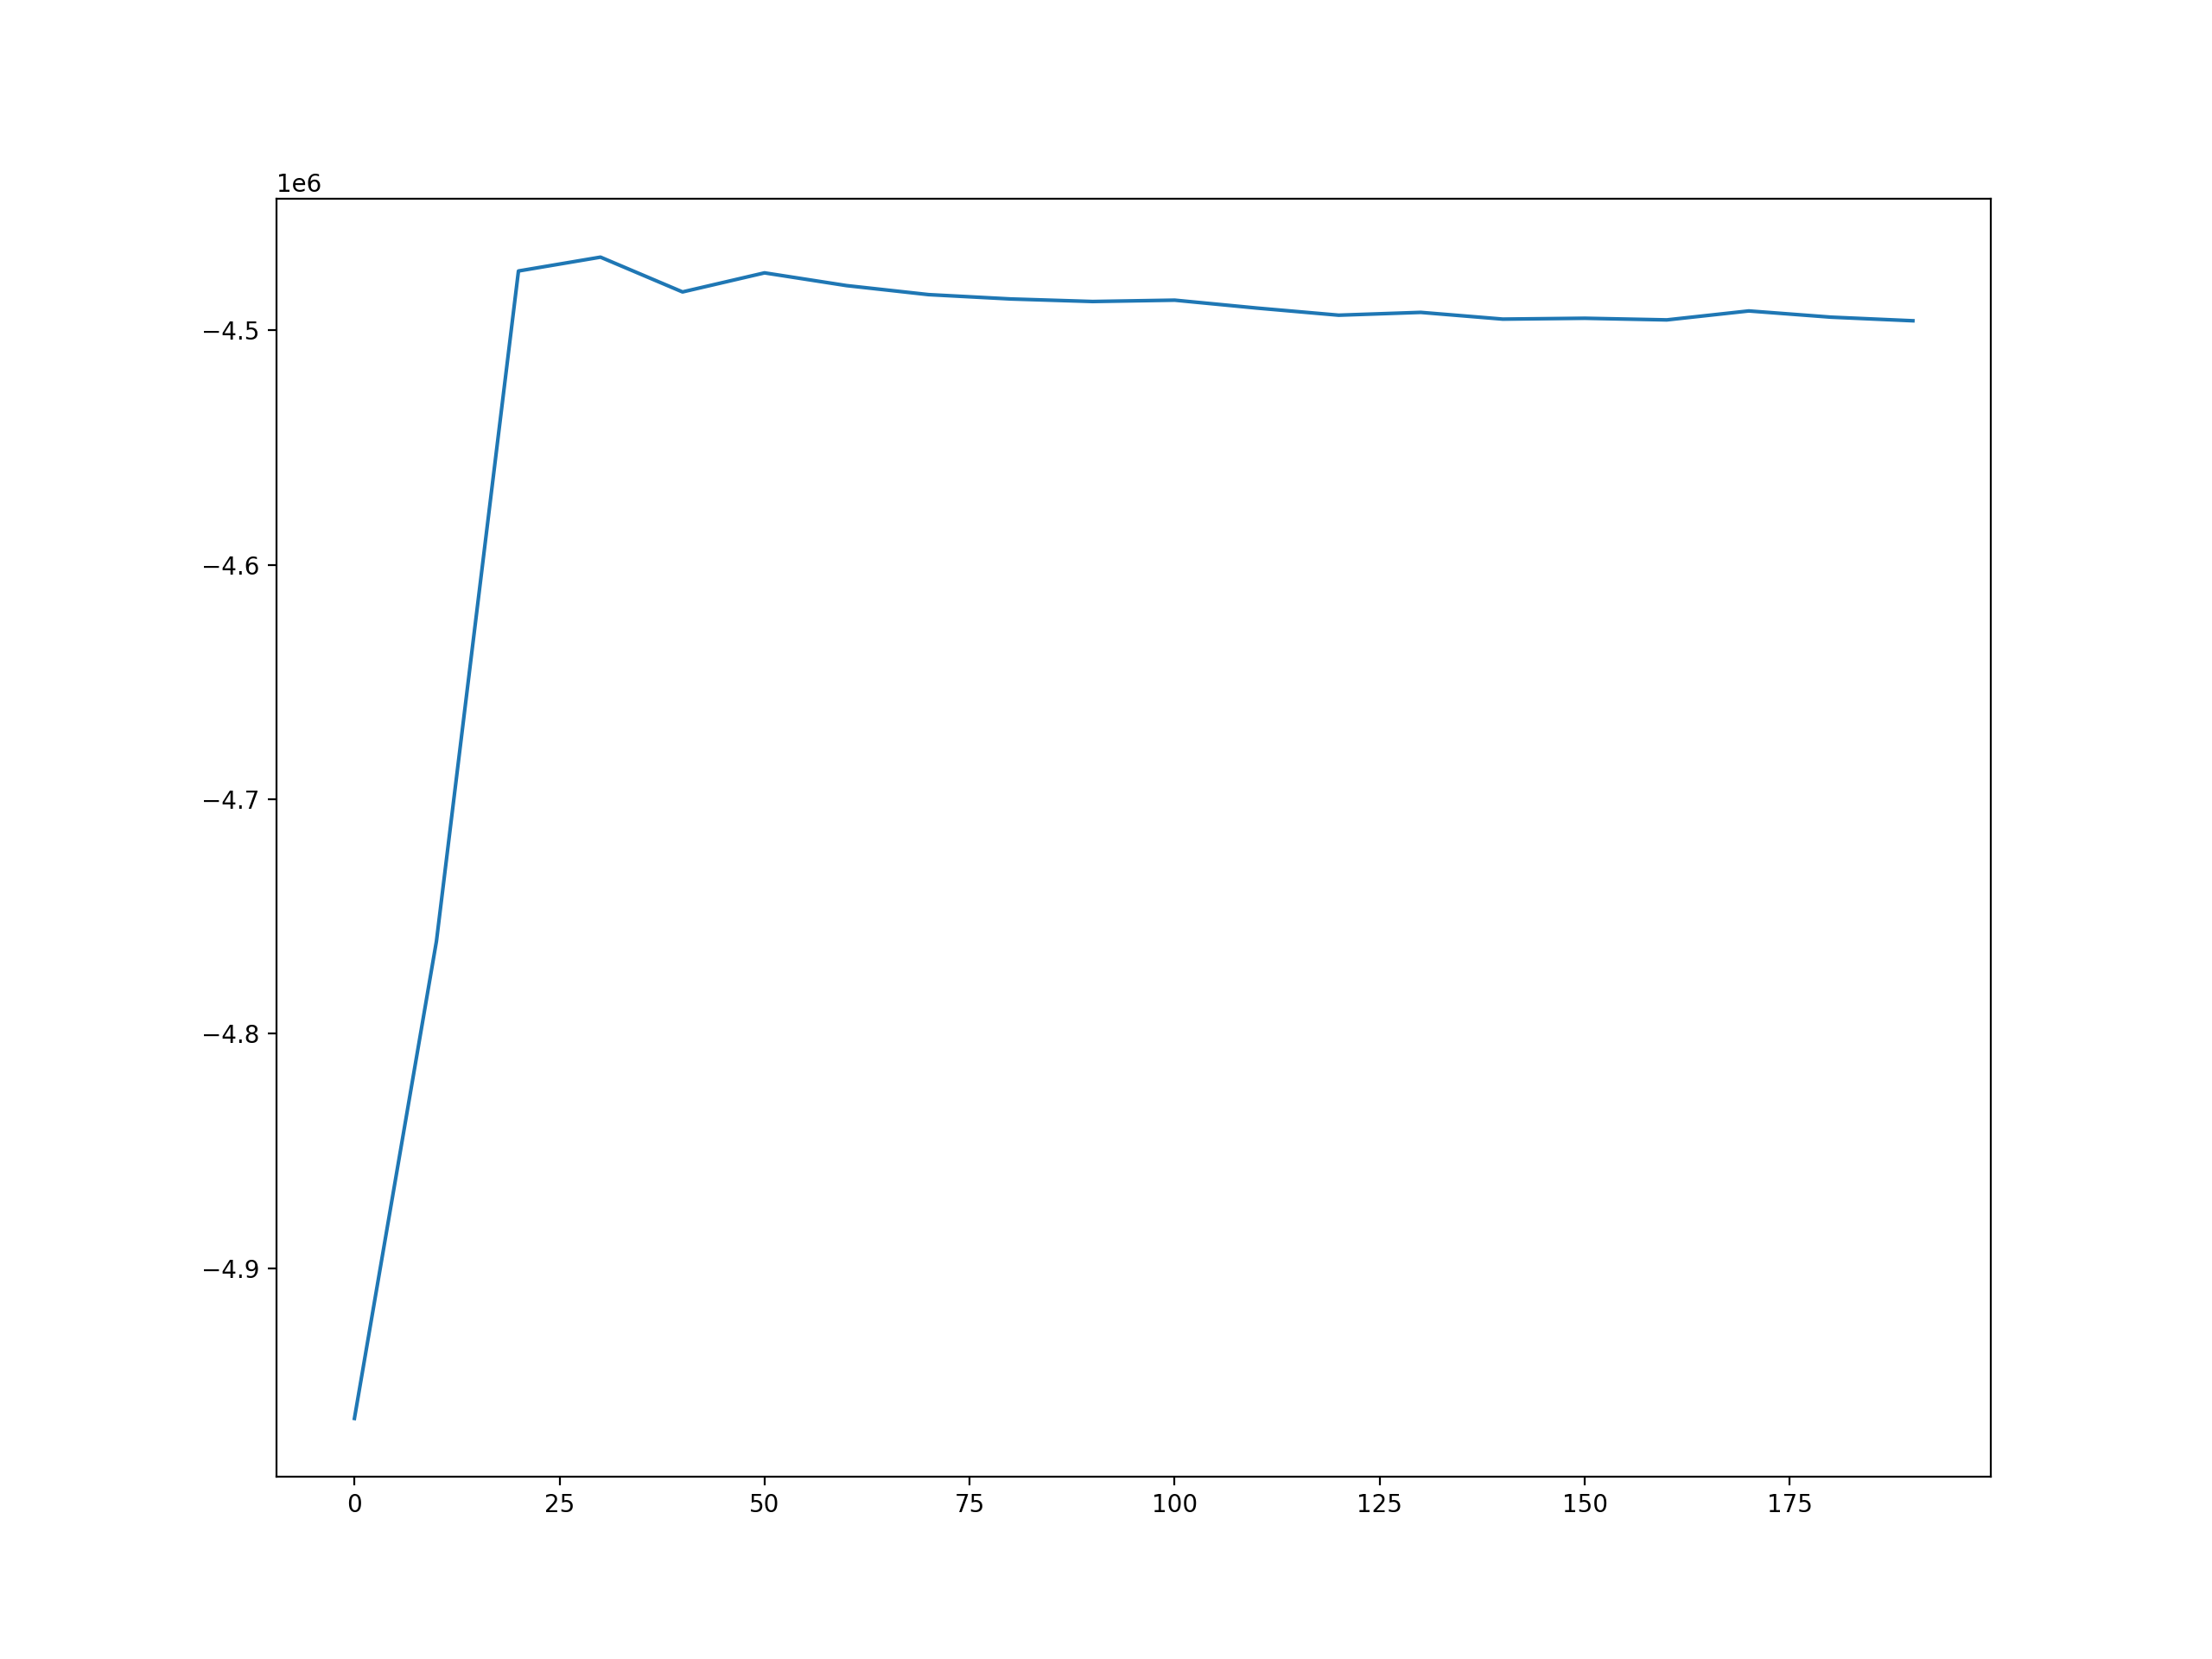

In [33]:
plt.figure()
plt.plot(cp_epochs, np.mean(cp_elbo, axis=1))

## Pick the best ip model based on early stopping

In [34]:
if ps['use_early_stopping']:
    best_cp_epoch = cp_epochs[np.argmax(np.mean(cp_elbo, axis=1))].astype('int')
    print('Best epoch is ' + str(best_cp_epoch) + '.')

    best_cp = torch.load(Path(ps['cp_save_folder']) / ('cp_' + str(best_cp_epoch) + '.pt'))    
    ip_eval_vi_collections = [VICollection.from_checkpoint(coll_d) for coll_d in best_cp['vi_collections']]
    for c_i, coll in enumerate(ip_eval_vi_collections):
        coll.props = ip_vi_collections[c_i].props
    ip_eval_priors = PriorCollection.from_checkpoint(best_cp['priors'])
    
else:
    ip_eval_vi_collections = ip_vi_collections
    ip_eval_priors = ip_priors
    
ip_eval_posteriors = {s_n: ip_eval_vi_collections[s_i].posteriors for s_i, s_n in enumerate(subjects)}

Best epoch is 30.


## Infer latents with the ip models for the validation data

In [35]:
ip_validation_latent_posts ={s_n: infer_latents(n_latent_vars=ps['n_latent_vars'],
                                                vi_collection=ip_eval_vi_collections[s_i],
                                                data=torch.tensor(validation_data_conc[s_n]),
                                                fit_opts={'n_epochs': 1000, 'init_lr':.1, 'update_int':None, 
                                                          'milestones': [500]}, 
                                                device=devices[0])[0]
                         for s_i, s_n in enumerate(subjects)}

In [36]:
ip_fitter.distribute(devices=[torch.device('cpu')])

## View fitting log for ip models

<IPython.core.display.Javascript object>


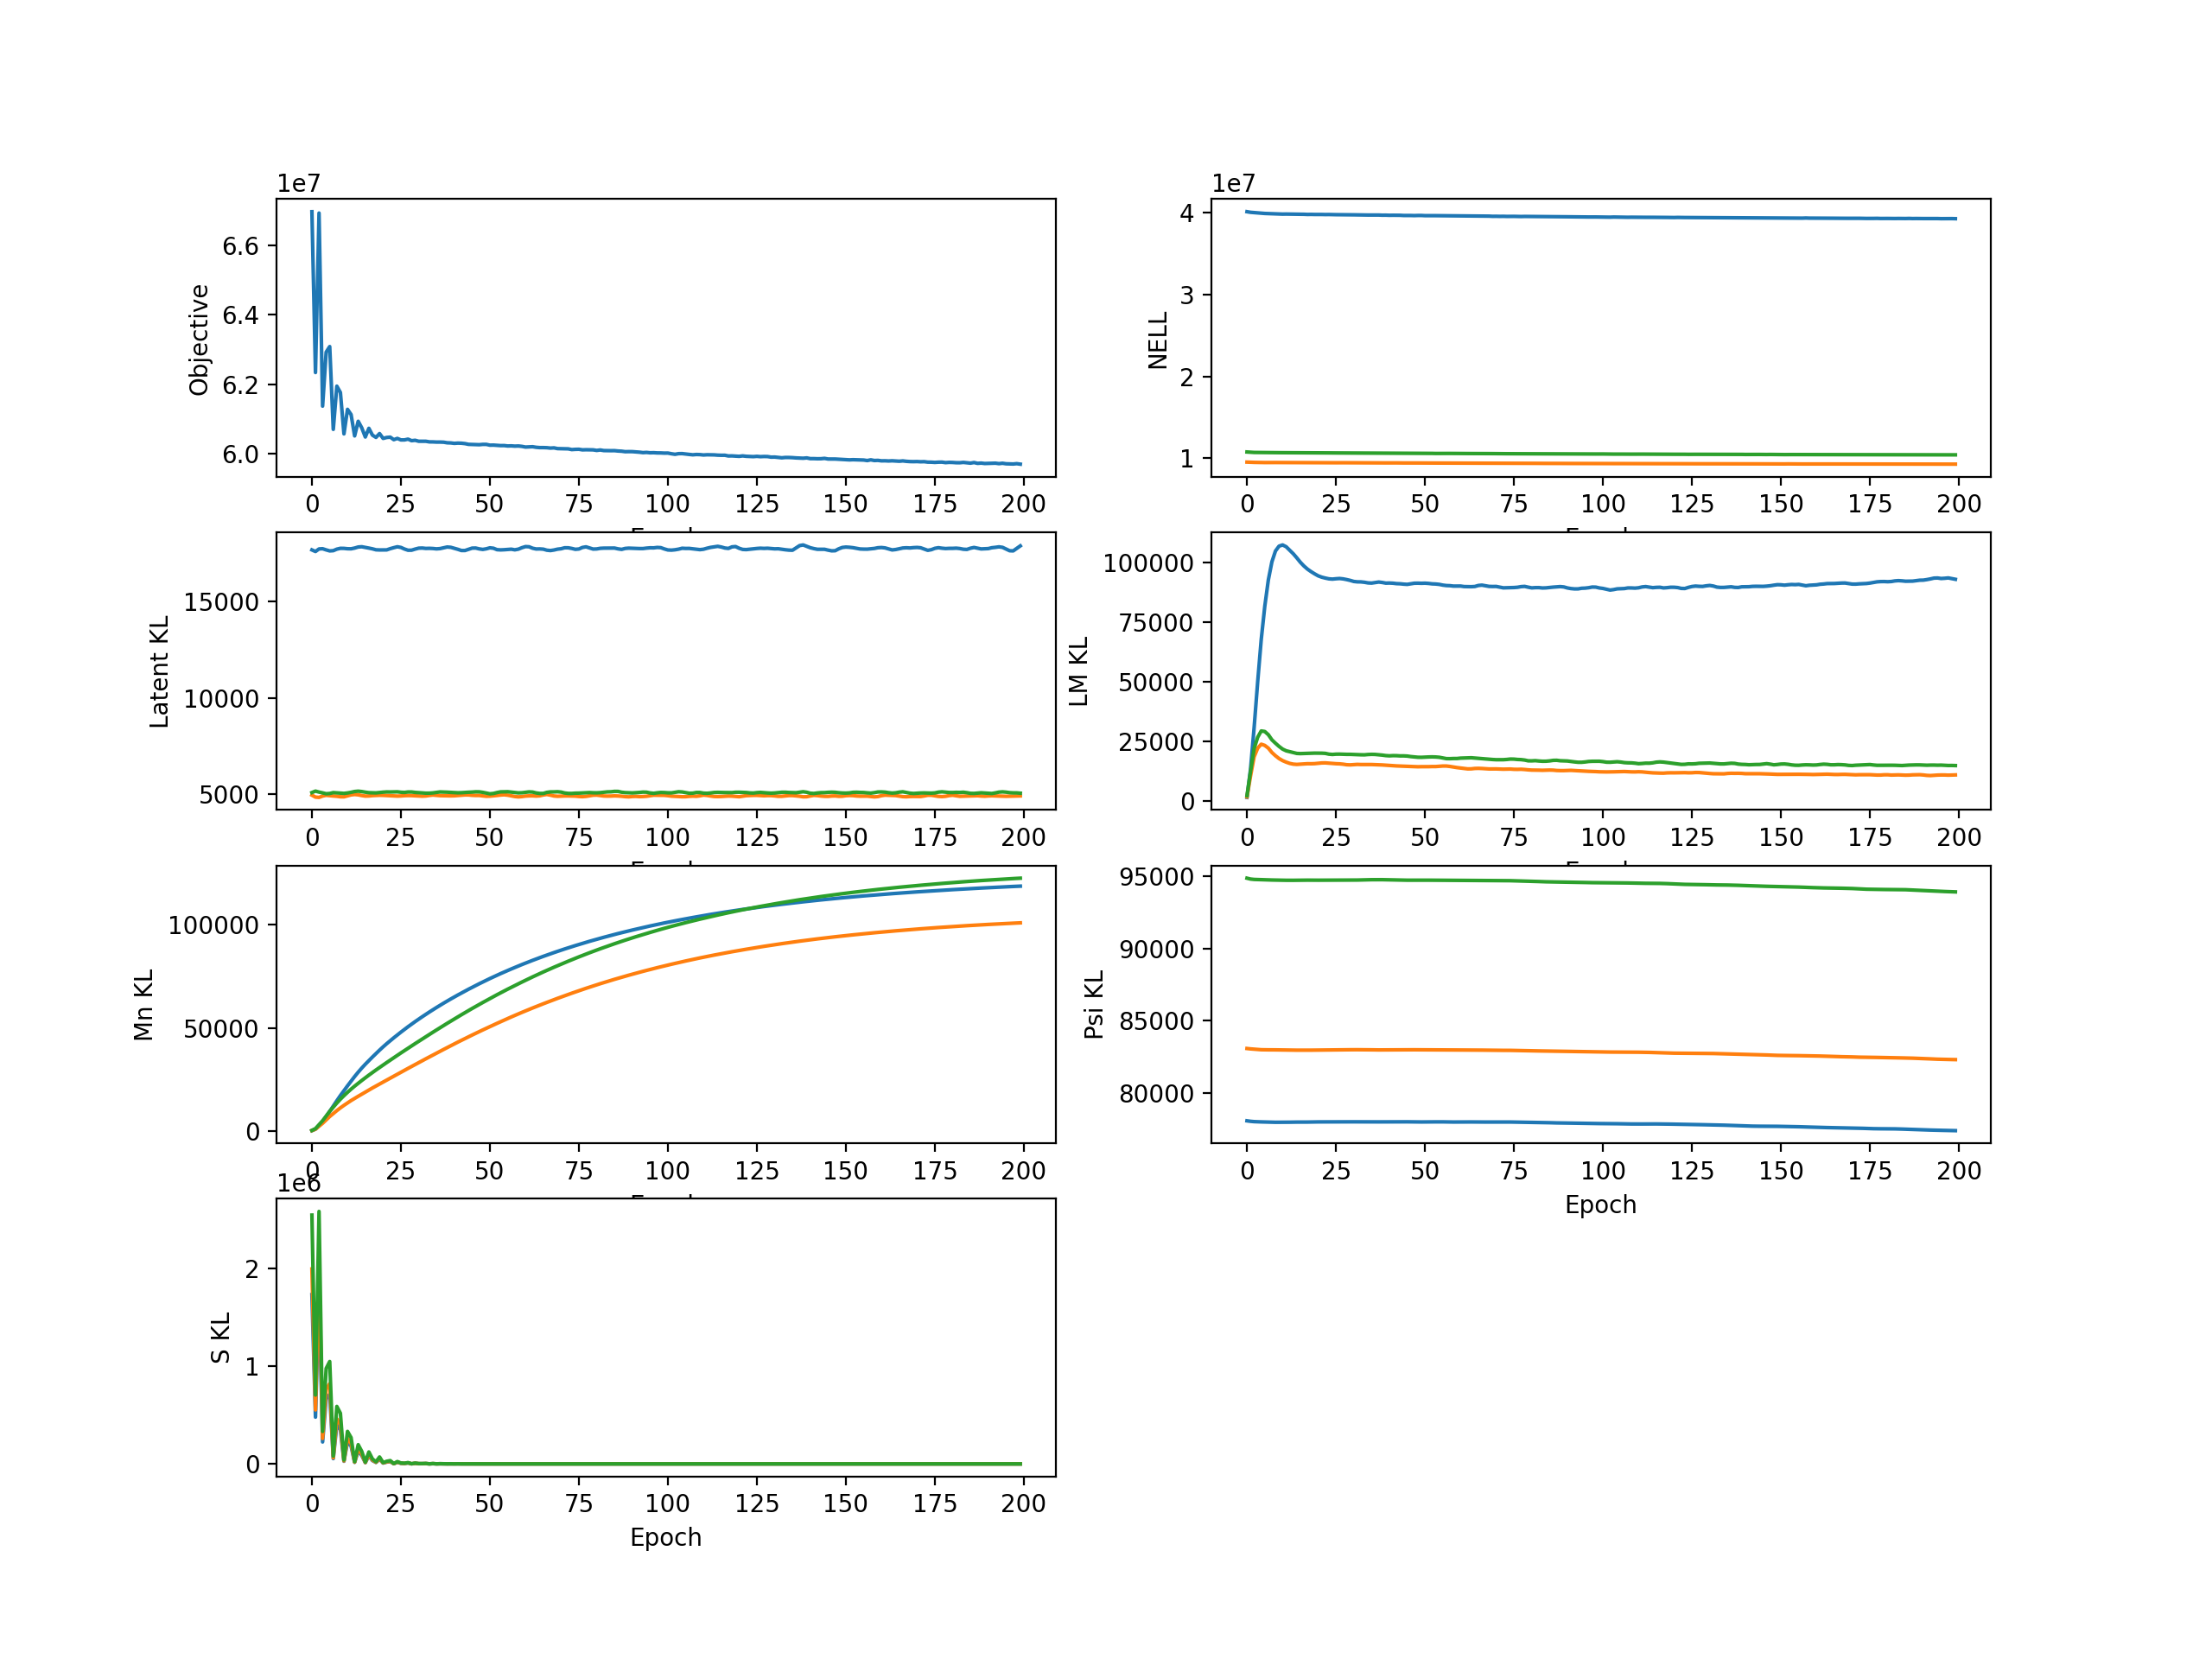

In [37]:
ip_fitter.plot_log(ip_log)

## View latents estimated with the ip models

In [38]:
view_validaton = False # True if we should view validation latents

In [39]:
if view_validaton:
    ip_latents = {s_n: ip_validation_latent_posts[s_n].latent_post.mns.detach().numpy() for s_n in subjects}
else:
    ip_latents = {s_n: ip_posteriors[s_n].latent_post.mns.detach().numpy() for s_n in subjects}

In [40]:
ip_lm_conc = torch.cat([post.lm_post(props) for post, props in zip(ip_posteriors.values(), neuron_locs.values())],
                       dim=0).detach().numpy()

In [41]:
ip_latents_o = {s_n: orthonormalize(lm=ip_lm_conc, latents=latents_n) for s_n, latents_n in ip_latents.items()}
ip_latents_o = {s_n: vls[1] for s_n, vls in ip_latents_o.items()}

<IPython.core.display.Javascript object>


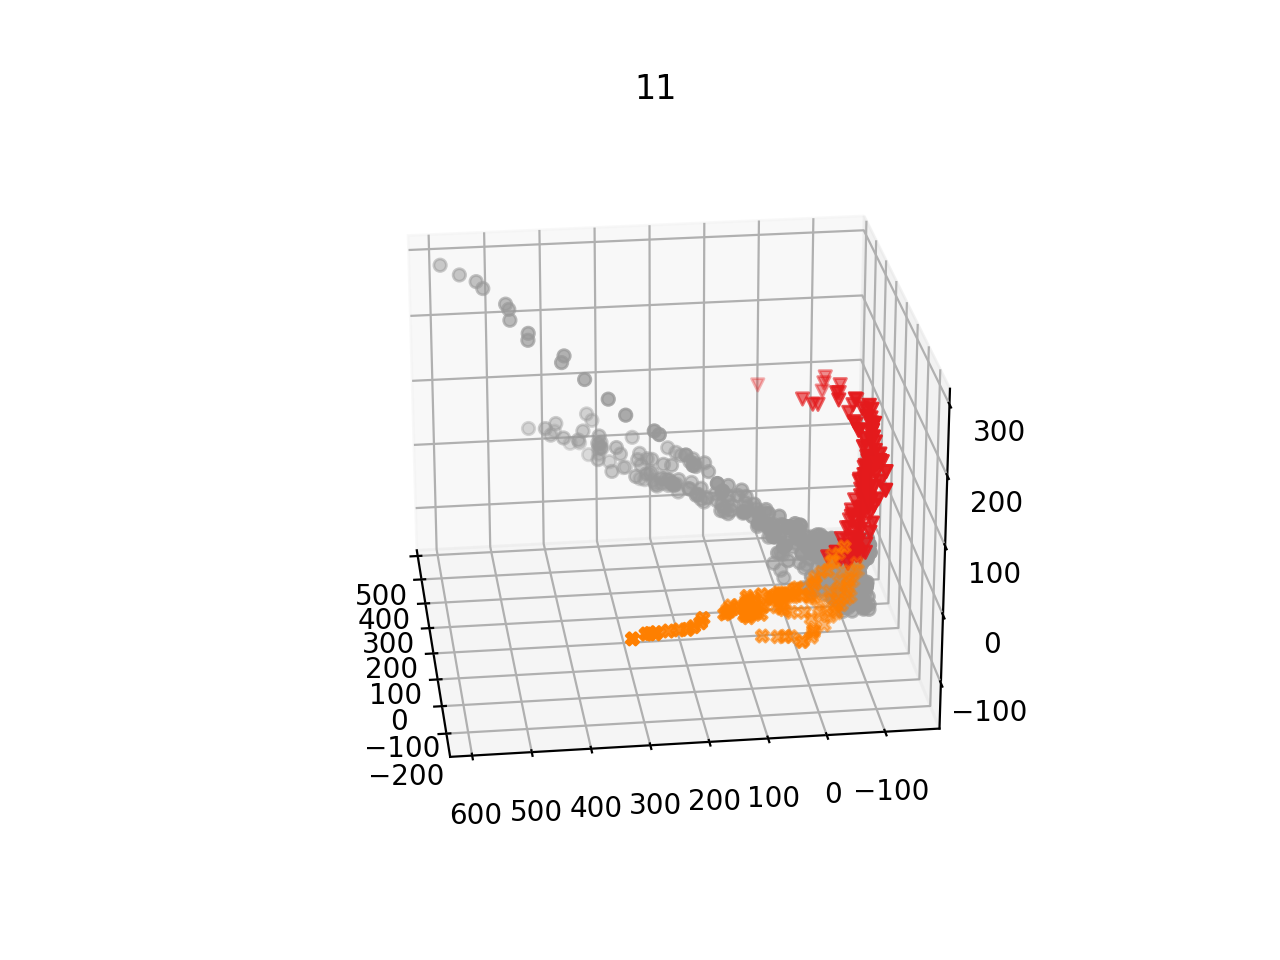

In [47]:
start_dim=0

plt.figure()
ax = plt.subplot(1,1,1, projection='3d')

for s_n in subjects:
    plot_latents = ip_latents_o[s_n]
    if view_validaton:
        plot_labels = validation_labels_conc[s_n]
    else:
        plot_labels = fit_labels_conc[s_n]
    
    for sp, sp_lbl in label_map.items():
        sp_clr = subperiod_clrs[sp]
        sp_inds = plot_labels == sp_lbl
        ax.scatter(plot_latents[sp_inds,start_dim+0], plot_latents[sp_inds,start_dim+1], 
                   plot_latents[sp_inds,start_dim+2], color=sp_clr, marker=subject_markers[s_n])
    plt.title(str(s_n))

## Visualize loading matrices across space for the ip models

In [43]:
vis_comp = 1

In [44]:
ip_lm_o_conc = orthonormalize(lm=ip_lm_conc)
ip_lm_o_conc = ip_lm_o_conc[0]
ip_lm_o = dict()
cur_start = 0
for s_n in subjects:
    n_vars_n = fit_data_conc[s_n].shape[1]
    ip_lm_o[s_n] = ip_lm_o_conc[cur_start:cur_start+n_vars_n]
    cur_start += n_vars_n

<IPython.core.display.Javascript object>


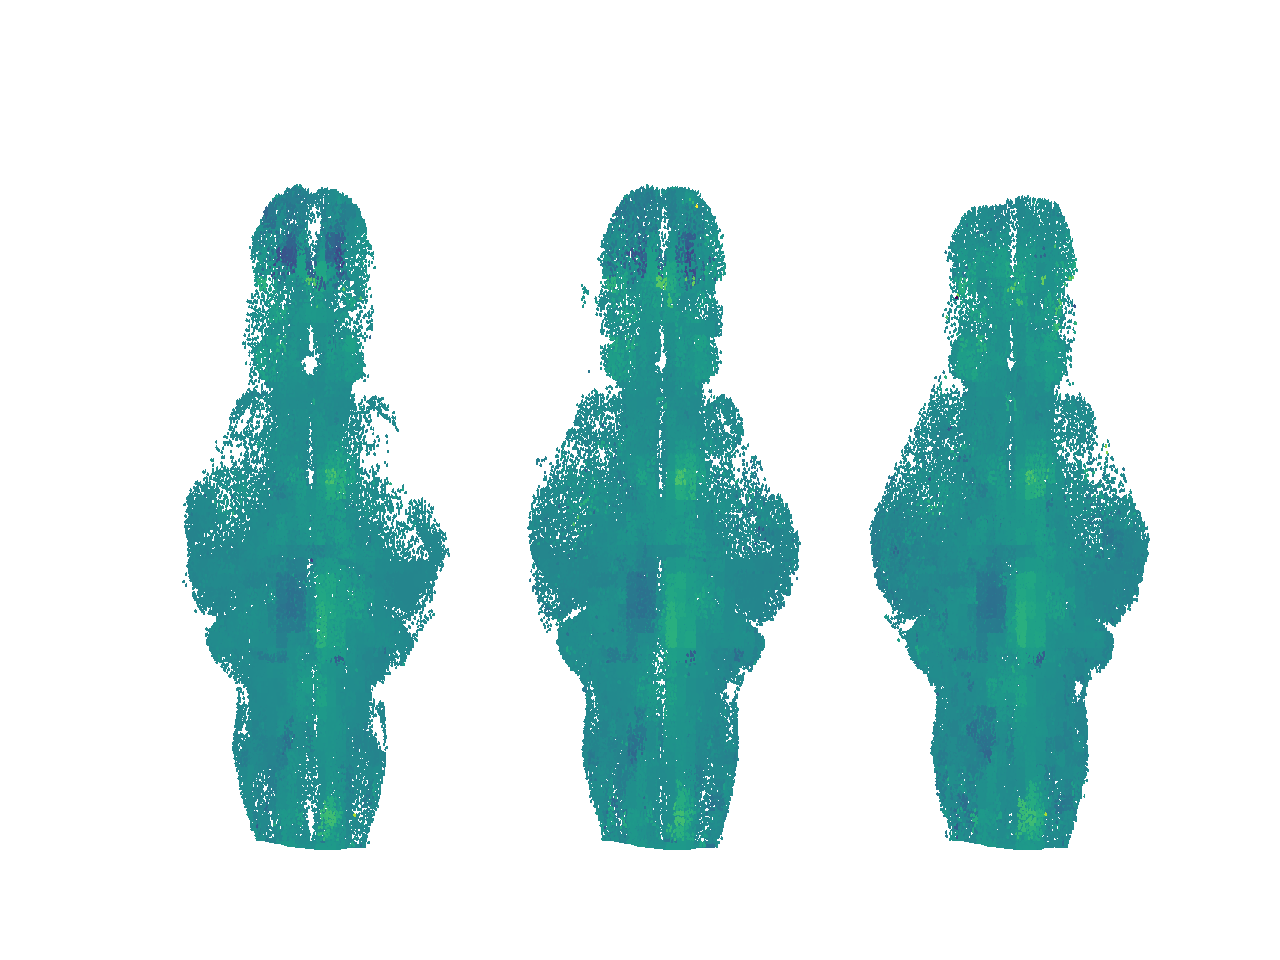

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

In [46]:
mode_imgs = dict()
for s_n in subjects:
    neuron_locs_n = neuron_locs[s_n]
    
    lm_n = ip_lm_o[s_n]
    
    mode_imgs[s_n], _ = max_project_pts(dot_positions=neuron_locs_n.numpy()[:,[0,1]].astype('float'),
                                        dot_vls=lm_n[:,vis_comp], 
                                        box_position=np.asarray([[0, 0], [990, 610]]), 
                                        n_divisions=np.asarray([990, 610]), 
                                        dot_dim_width=np.asarray([5,5]))
    
plt.figure()
cmp_n_mats([mode_imgs[k] for k in mode_imgs.keys()])   

## Find a good projection that shows the differences in classes and visualize it

In [49]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [74]:
all_ip_latents = np.concatenate([ip_latents[s_n] for s_n in subjects], axis=0)
if view_validaton:
    all_labels = np.concatenate([validation_labels_conc[s_n] for s_n in subjects])
else:
    all_labels = np.concatenate([fit_labels_conc[s_n] for s_n in subjects])

In [75]:
lda_mdl = LinearDiscriminantAnalysis()
lda_mdl.fit(all_ip_latents, all_labels)
proj = lda_mdl.transform(all_ip_latents)

<IPython.core.display.Javascript object>


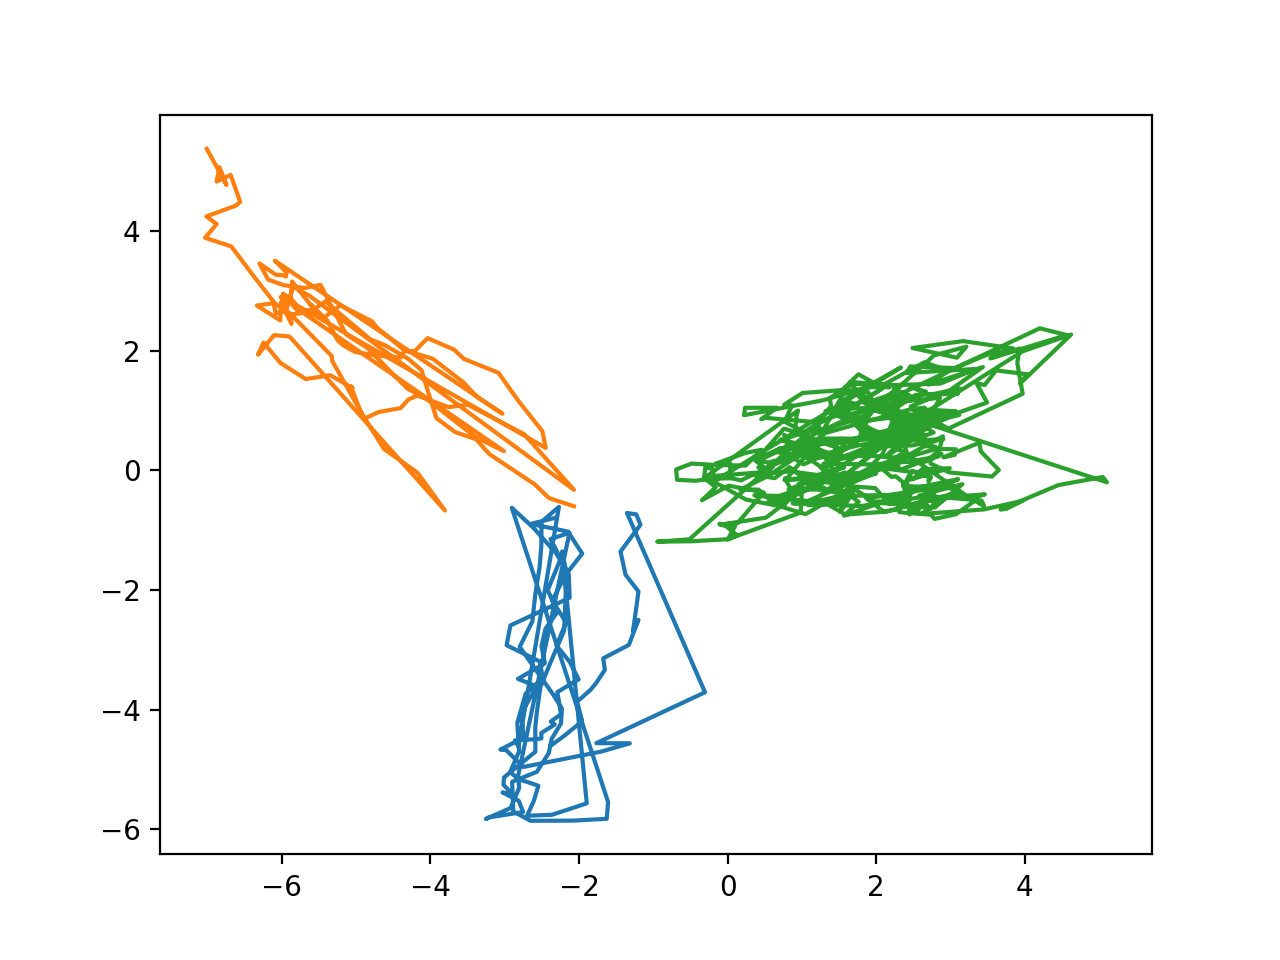

In [76]:
plt.figure()
ax = plt.subplot(1,1,1)

for lbl in np.unique(all_labels):
    plot_inds = all_labels == lbl
    plt.plot(proj[plot_inds,0], proj[plot_inds,1])

In [68]:
np.unique(all_labels)

array([0., 1., 2.])